# **Classification Model for SpaceX  Falcon9 first stage Landing Prediction**


**Disclaimer:**

This Jupyter notebook was developed as part of my final project submissions for the [IBM Data Science Professional](https://www.coursera.org/professional-certificates/ibm-data-science) course. The content has been adapted, merged, and presented in this form to showcase the skills and knowledge acquired during the course.

**Note:**

- The original content and materials are based on the coursework provided by IBM.
- All proprietary logos, images, and specific branding have been removed.
- This notebook is shared for educational and illustrative purposes only.
- Any opinions or views expressed in this notebook are those of the author and do not necessarily reflect the views of IBM.

**Copyright Notice:**

The original materials, including but not limited to code snippets, datasets, and concepts, are the intellectual property of IBM. All rights are reserved by IBM.

**Project:**

Here, we will develop a machine learning model to predict if the Falcon 9 first stage will land successfully. 
SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. 

*Extra parts containing Webscrapping to obtain launch records, EDA with SQL and a Dashboard App were not included, as their exclusion does not impact the completeness of the objectives of the project. All notebooks including the excluded ones can be found in this [Github link](https://github.com/deexposito/Data-Science-Project-1-SpaceX).*


## 1) DATA COLLECTION


We will make a get request to the SpaceX API to get the launch data.

#### 1.1) Importing Libraries and Defining Auxiliary Functions


In [84]:
import requests # http requests
import pandas as pd
import numpy as np
import datetime, warnings, folium, wget
import matplotlib.pyplot as plt
import seaborn as sns

from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Below we will define a series of helper functions that will help us use the SpaceX API to extract information using identification numbers in the launch data.

From the <code>rocket</code> column we would like to learn the booster name.


In [3]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.


In [4]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.


In [5]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.


In [6]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

#### 1.2) Request and parse data

Now let's start requesting rocket launch data from SpaceX API. The SpaceX url provides updated launch information [SpaceX launches](https://api.spacexdata.com/v4/launches/past), so data can vary depending on when it is used. In our case we will use a static response provided from IBM:


In [7]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
response = requests.get(static_json_url)
response.status_code # 200 --> no error

200

In [8]:
# Use json_normalize meethod to convert the json result into a dataframe
data = pd.json_normalize(response.json())
data.head()

,static_fire_date_utc,static_fire_date_unix,tbd,net,window,rocket,success,details,crew,ships,capsules,payloads,launchpad,auto_update,failures,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,True,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,"Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,True,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]",2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,True,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/3d/86/cnu0pan8_o.png,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,True,"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,True,[],4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_succes

You will notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.


In [9]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.


In [10]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

These functions will apply the outputs globally to the above variables. Let's take a looks at <code>BoosterVersion</code> variable. Before we apply  <code>getBoosterVersion</code> the list is empty:


In [11]:
BoosterVersion

[]

Now, let's apply <code> getBoosterVersion</code> function method to get the booster version


In [12]:
# Call getBoosterVersion
getBoosterVersion(data)

the list has now been update 


In [13]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

we can apply the rest of the  functions here:


In [14]:
# Call getLaunchSite
getLaunchSite(data)

In [15]:
# Call getPayloadData
getPayloadData(data)

In [16]:
# Call getCoreData
getCoreData(data)

Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.


In [17]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


Then, we need to create a Pandas data frame from the dictionary launch_dict.


In [18]:
# Create a data from launch_dict
data = pd.DataFrame(launch_dict)

In [19]:
# Let's take a look at the dataframe
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


#### 1.3) Filter the data to include only `Falcon 9` launches


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches using the <code>Booster Version</code> column.


In [20]:
df = data[data['BoosterVersion'] == 'Falcon 9']
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [21]:
df.shape

(90, 17)

Now that we have removed some values we should reset the <code>FlightNumber</code> column


In [22]:
warnings.filterwarnings('ignore')

df.loc[:,'FlightNumber'] = list(range(1, df.shape[0]+1))
df

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


----

## 2) DATA PRE-PROCESSING


#### 2.1) Missing values


We can see below that some of the rows are missing values in our dataset.


Before we can continue we must deal with these missing values. The <code>LandingPad</code> column will retain None values to represent when landing pads were not used, so we will keep it.


In [23]:
df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Calculate below the mean for the <code>PayloadMass</code> using the <code>.mean()</code>. Then use the mean and the <code>.replace()</code> function to replace `np.nan` values in the data with the mean you calculated.


In [24]:
# Replace the np.nan values with its mean value
payload_mean = df['PayloadMass'].mean()
df['PayloadMass'].replace(np.nan, payload_mean, inplace=True)

In [25]:
df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [42]:
# df.to_csv('data/dataset_part_1.csv', index=False)

Now we should have no missing values in our dataset except for in <code>LandingPad</code>.


#### 2.2.) Data types formatting 


Identify which columns are numerical and categorical:


In [26]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

The data contains several Space X  launch facilities: <a href='https://en.wikipedia.org/wiki/List_of_Cape_Canaveral_and_Merritt_Island_launch_sites'>Cape Canaveral Space</a> Launch Complex 40  <b>VAFB SLC 4E </b> , Vandenberg Air Force Base Space Launch Complex 4E <b>(SLC-4E)</b>, Kennedy Space Center Launch Complex 39A <b>KSC LC 39A </b>.The location of each Launch Is placed in the column <code>LaunchSite</code>


Next, let's see the number of launches for each site.

We use the method  <code>value_counts()</code> on  <code>LaunchSite</code>, <code>Orbit</code> and <code>Outcome</code> to determine the quantity of each category:


In [27]:
df['LaunchSite'].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

In [28]:
df['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

In [29]:
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.


In [30]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


We create a set of outcomes where the second stage did not land successfully:


In [31]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

Using the <code>Outcome</code>,  create a list where the element is zero if the corresponding  row  in  <code>Outcome</code> is in the set <code>bad_outcome</code>; otherwise, it's one. Then assign it to the variable <code>landing_class</code>:


In [32]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = []
for outcome in df['Outcome']:
    if outcome in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

This variable will represent the classification variable that represents the outcome of each launch. If the value is zero, the  first stage did not land successfully; one means  the first stage landed Successfully 


In [33]:
df['Class']= landing_class
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


We can use the following line of code to determine  the success rate:


In [34]:
df["Class"].mean()

0.6666666666666666

In [ ]:
# df.to_csv("data/dataset_part_2.csv", index=False)


----


### 3) EXPLORATORY DATA ANALYSIS


First, let's get a quick statistical summary of our dataset:


In [35]:
df.describe(include='all')

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
count,90.000000,90,90,90.000000,90,90,90,90.000000,90,90,90,64,90.000000,90.000000,90,90.000000,90.000000,90.000000
unique,NaN,90,1,NaN,11,3,8,NaN,2,2,2,5,NaN,NaN,53,NaN,NaN,NaN
top,NaN,2010-06-04,Falcon 9,NaN,GTO,CCSFS SLC 40,True ASDS,NaN,True,False,True,5e9e3032383ecb6bb234e7ca,NaN,NaN,B1049,NaN,NaN,NaN
freq,NaN,1,90,NaN,27,55,41,NaN,70,53,71,35,NaN,NaN,6,NaN,NaN,NaN
mean,45.500000,NaN,NaN,6123.547647,NaN,NaN,NaN,1.788889,NaN,NaN,NaN,NaN,3.500000,3.188889,NaN,-86.366477,29.449963,0.666667
std,26.124701,NaN,NaN,4732.115291,NaN,NaN,NaN,1.213172,NaN,NaN,NaN,NaN,1.595288,4.194417,NaN,14.149518,2.141306,0.474045
min,1.000000,NaN,NaN,350.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,-120.610829,28.561857,0.000000
25%,23.250000,NaN,NaN,2510.750000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2.000000,0.000000,NaN,-80.603956,28.561857,0.000000
50%,45.500000,NaN,NaN,4701.500000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,4.000000,1.000000,NaN,-80.577366,28.561857,1.000000
75%,67.750000,NaN,NaN,8912.750000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,5.000000,4.000000,NaN,-80.577366,28.608058,1.000000


#### 3.1) Relationship between Flight Number and Payload Mass

First, let's try to see how the `FlightNumber` (indicating the continuous launch attempts) and `Payload` variables would affect the launch outcome.

We can plot out the <code>FlightNumber</code> vs. <code>PayloadMass</code>and overlay the outcome of the launch. 


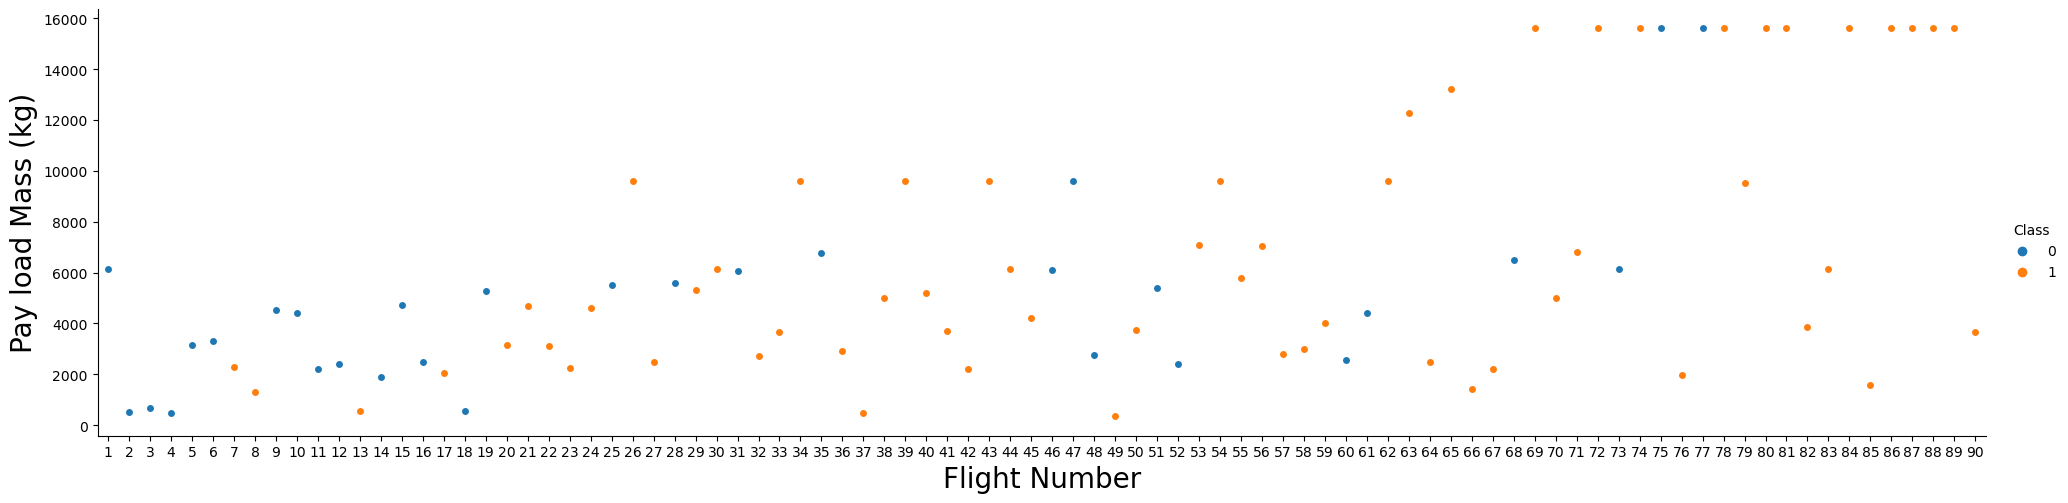

In [37]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 4)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the less likely the first stage will return.

#### 3.2) Relationship between Flight Number and Launch Site

We use the function <code>catplot</code> to plot <code>FlightNumber</code> vs <code>LaunchSite</code> according to the <code>Class</code> (outcome).

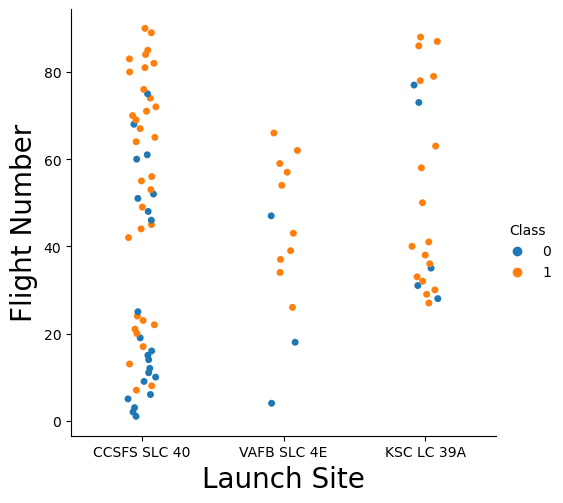

In [38]:
# Plot a scatter point chart with x axis to be Flight Number and y axis to be the launch site, and hue to be the class value
sns.catplot(y="FlightNumber", x="LaunchSite", hue="Class", data=df)
plt.xlabel("Launch Site",fontsize=20)
plt.ylabel("Flight Number",fontsize=20)
plt.show()

In each launch site we can observe that as flight number increases, the successful rate also increases, so we see an improvement as more rockets are launched.
We can see that CCAFS SLC 40 launch site it is the most used and as a consequence it also has more failures than the others.

In [40]:
for site in df['LaunchSite'].unique():
    print(f'{site} success rate: ', df[df['LaunchSite'] == site]['Class'].mean())

CCSFS SLC 40 success rate:  0.6
VAFB SLC 4E success rate:  0.7692307692307693
KSC LC 39A success rate:  0.7727272727272727


We see that different launch sites have different success rates.  <code>CCAFS LC-40</code>, has a success rate of 60 %, while  <code>KSC LC-39A</code> and <code>VAFB SLC 4E</code> have a success rate of 77%.

#### 3.3) Relationship between Payload Mass and Launch Site


We also want to observe if there is any relationship between launch sites and their payload mass.


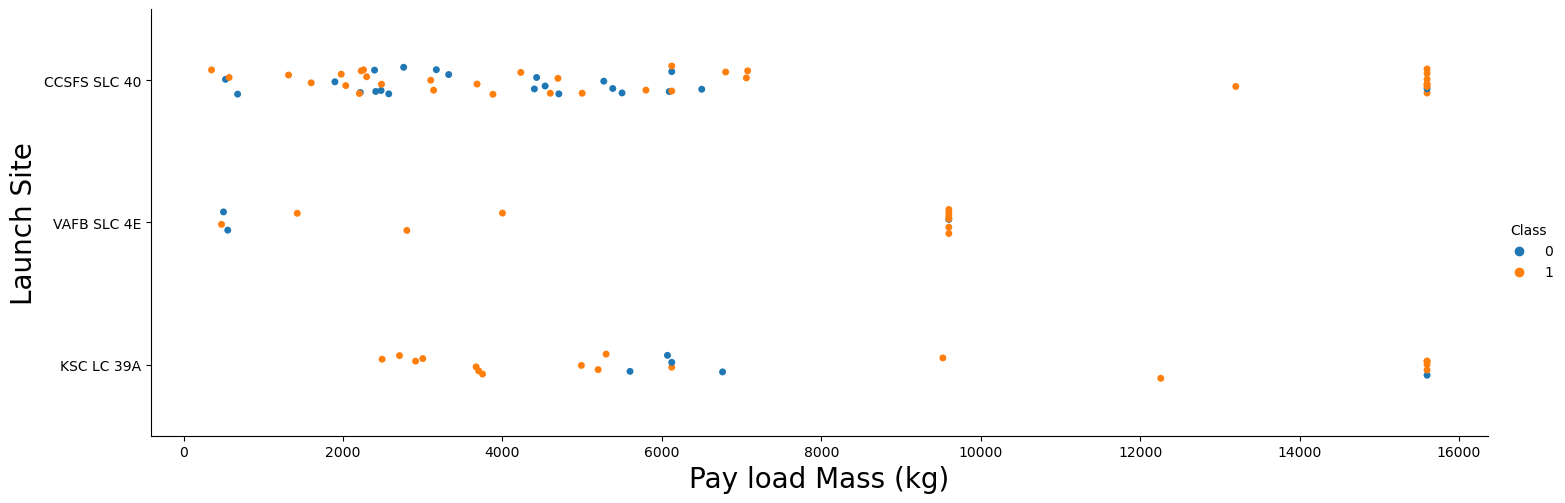

In [41]:
# Plot a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=df, aspect=3)
plt.xlabel("Pay load Mass (kg)",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

Now if you observe Payload Vs. Launch Site scatter point chart you will find for the VAFB-SLC  launchsite there are no  rockets  launched for  heavypayload mass (greater than 10000).


#### 3.4) Relationship between Success rate and Orbit type


Next, we want to visually check if there are any relationship between success rate and orbit type.


Let's create a `bar chart` for the sucess rate of each orbit


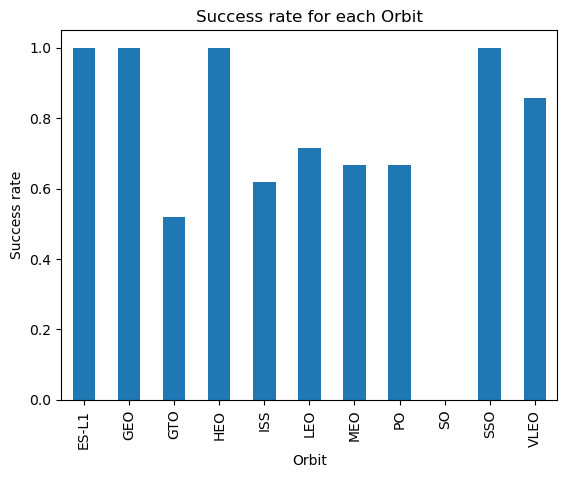

In [42]:
# HINT use groupby method on Orbit column and get the mean of Class column
mean = df.groupby('Orbit')['Class'].mean()
mean.plot(kind='bar')
plt.title('Success rate for each Orbit')
plt.ylabel('Success rate')
plt.xlabel('Orbit')
plt.show()

Analyze the ploted bar chart try to find which orbits have high sucess rate.

We see a great success in ES-L1, GEO, HEO and SSO orbits. SO orbits always let to failure.

#### 3.5) Relationship between Flight Number and Orbit type


For each orbit, we want to see if there is any relationship between <code>FlightNumber</code> and <code>Orbit</code> type.


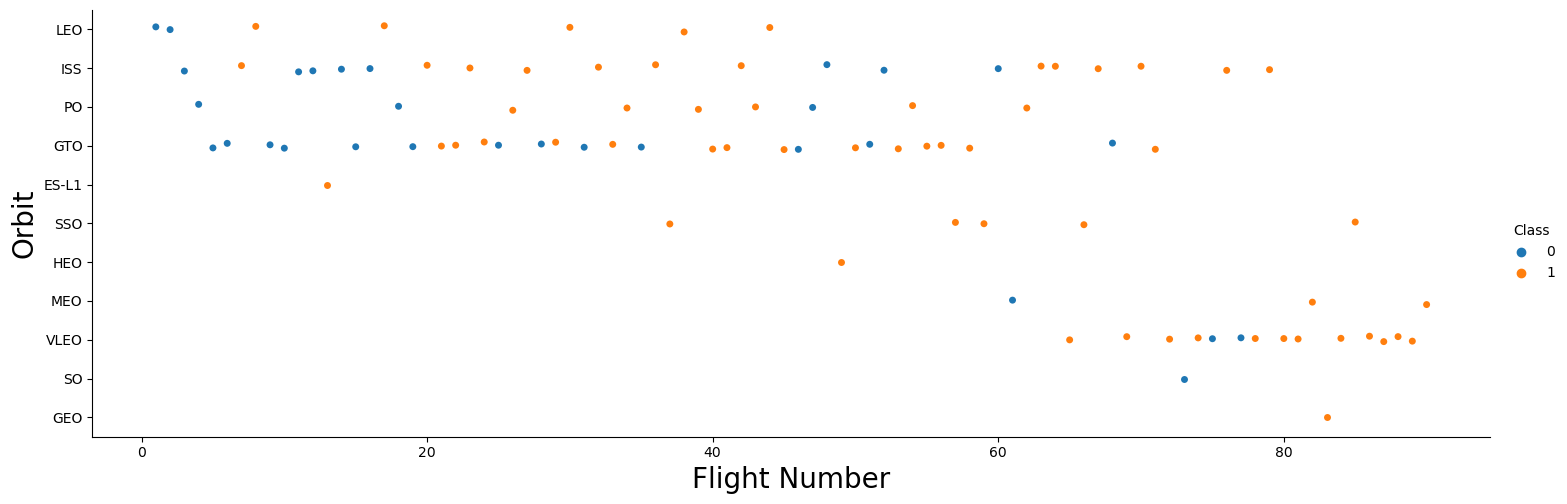

In [43]:
# Plot a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=df, aspect=3)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

You should see that in the LEO orbit the Success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in GTO orbit.


#### 3.6) Relationship between Payload Mass and Orbit type


Similarly, we can plot the <code>PayloadMass</code> vs. <code>Orbit</code> scatter point charts to reveal their relationship.


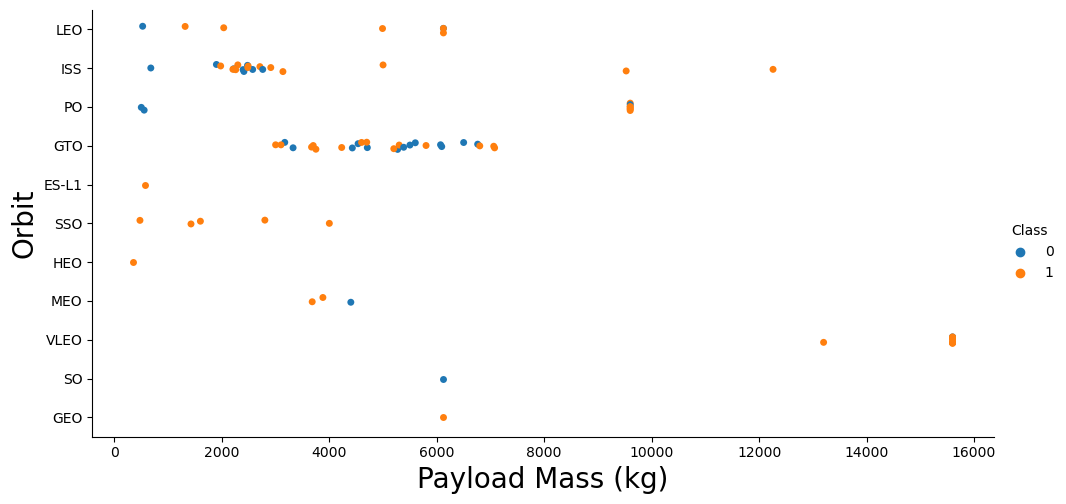

In [45]:
# Plot a scatter point chart with x axis to be Payload and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=df, aspect=2)
plt.xlabel("Payload Mass (kg)",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.   

However for GTO we cannot see a pattern regarding Payload Mass. The other Orbit types have fewer launches, and that can be not enough to take conclusions.




#### 3.7) Yearly trend of Success Rate


You can plot a line chart with x axis to be <code>Year</code> and y axis to be average success rate, to get the average launch success trend. 


The function will help you get the year from the date:


In [58]:
# A function to Extract years from the date 
year=[]
def Extract_year(date):
    return str(date.year)

df['Year'] = df['Date'].apply(Extract_year)

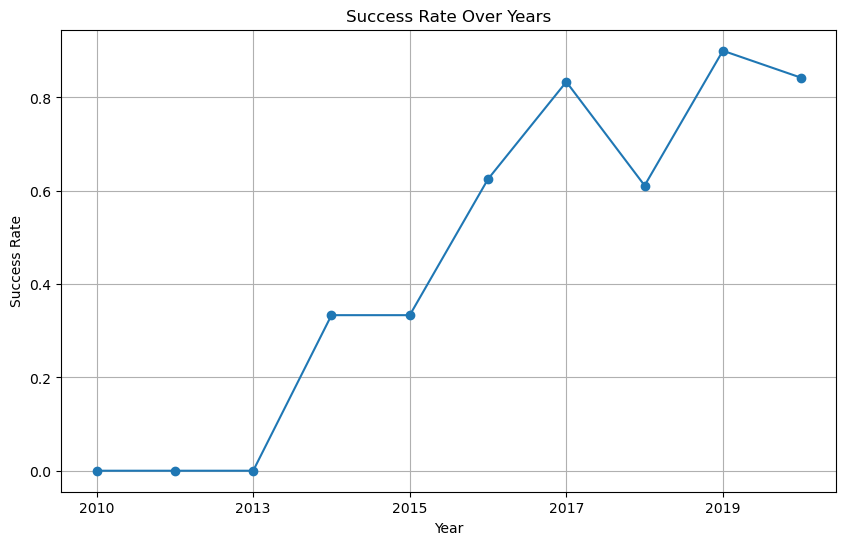

In [60]:
# Plot a line chart with x axis to be the extracted year and y axis to be the success rate
warnings.filterwarnings('ignore')

for i, value in enumerate(year):
    df['Year'][i] = value

success_rate_by_year = df.groupby('Year')['Class'].mean()

success_rate_by_year.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Success Rate Over Years')
plt.xlabel('Year')
plt.ylabel('Success Rate')
plt.grid(True)
plt.show()


We can observe that the success rate since 2013 kept increasing till 2017 (stable in 2014).


----

## 4) FEATURE ENGINEERING


After the EDA, we have obtained some preliminary insights about how each important variable would affect the success rate, and we will select the features that will be used in success prediction in the future module:


In [61]:
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,Year
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0,2010
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0,2012
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0,2013
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0,2013
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0,2013


We can see that columns such as <code>Date</code>, <code>BoosterVersion</code> (all are Falcon 9), <code>Outcome</code> (we have <code>Class</code>), <code>Longitude</code>, <code>Latitude</code> (both associated with <code>LaunchSite</code>) and <code>Year</code> can give no important information in terms of class prediction.

In [62]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


 ### 4.1) Encoding categorical variables


Use the function <code>get_dummies</code> and <code>features</code> dataframe to apply OneHotEncoder to the column <code>Orbits</code>, <code>LaunchSite</code>, <code>LandingPad</code>, and <code>Serial</code>. 


In [63]:
cat_columns = ['Orbit', 'LaunchSite','LandingPad', 'Serial']
features_one_hot = pd.get_dummies(features, columns=cat_columns)
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,525.000000,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3,677.000000,1,False,False,False,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,500.000000,1,False,False,False,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,3170.000000,1,False,False,False,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


 ### 4.2) Numeric columns as float


Now that our <code>features_one_hot</code> dataframe only contains numbers cast the entire dataframe to variable type <code>float64</code>


In [64]:
features_one_hot = features_one_hot.astype('float64')
features_one_hot.dtypes

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 80, dtype: object

We can now export it to a <b>CSV</b> for the next section,but to make the answers consistent, in the next lab we will provide data in a pre-selected date range. 


<code>features_one_hot.to_csv('dataset_part_3.csv', index=False)</code>


In [39]:
# features_one_hot.to_csv('data/dataset_part_3.csv', index=False)

----

### 5) FOLIUM DASHBOARD (GEOLOCATION ANALYSIS)


The launch success rate may also depend on the location and proximities of a launch site, i.e., the initial position of rocket trajectories. Finding an optimal location for building a launch site certainly involves many factors and hopefully we could discover some of the factors by analyzing the existing launch site locations.


### 5.1) Mark launch sites in the map


First, let's try to add each site's location on a map using site's latitude and longitude coordinates


The following dataset with the name `spacex_launch_geo.csv` from IBM is an augmented dataset with latitude and longitude added for each site.
We can also extract the <code>LaunchSite</code> and their <code>Latitude</code> and <code>Longitude</code> values.


In [66]:
# Uncomment to get data from the IBM course database
# spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
# spacex_df=pd.read_csv(spacex_csv_file)

spacex_df = pd.read_csv("data/spacex_launch_geo.csv")

In [67]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map.


We first need to create a folium `Map` object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.


In [68]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

We could use `folium.Circle` to add a highlighted circle area with a text label on a specific coordinate. For example, 


In [69]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

and you should find a small red circle near the city of Houston and you can zoom-in to see a larger circle. 


Now, let's add a circle for each launch site in data frame `launch_sites`


In [70]:
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for launch in launch_sites_df.values:
    coordinate = [launch[1], launch[2]]
    circle = folium.Circle(coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup(launch[0]))

    marker = folium.map.Marker(
        coordinate,

        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % launch[0],
            )
        )
    site_map.add_child(circle)
    site_map.add_child(marker)

In [71]:
site_map

The generated map with marked launch sites should look similar to the following:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_markers.png">
</center>


We can find 3 of the launch sites close to the Cape Canaveral Space Station, which makes sense. In fact both CCAF launch sites are practically from the same point. If we go to the west, we find the other launch site next to the Vandenberg Space Force Base (Space launch complex 4).

They are all located in the coast, probably for safety concerns.

### 5.2) Mark the success/failed launches for each site on the map


Next, let's try to enhance the map by adding the launch outcomes for each site, and see which sites have high success rates.
Recall that data frame spacex_df has detailed launch records, and the `class` column indicates if this launch was successful or not


In [72]:
spacex_df.tail(10)

,Launch Site,Lat,Long,class
46,KSC LC-39A,28.573255,-80.646895,1
47,KSC LC-39A,28.573255,-80.646895,1
48,KSC LC-39A,28.573255,-80.646895,1
49,CCAFS SLC-40,28.563197,-80.576820,1
50,CCAFS SLC-40,28.563197,-80.576820,1
51,CCAFS SLC-40,28.563197,-80.576820,0
52,CCAFS SLC-40,28.563197,-80.576820,0
53,CCAFS SLC-40,28.563197,-80.576820,0
54,CCAFS SLC-40,28.563197,-80.576820,1
55,CCAFS SLC-40,28.563197,-80.576820,0


Next, let's create markers for all launch records. 
If a launch was successful `(class=1)`, then we use a green marker and if a launch was failed, we use a red marker `(class=0)`


Note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate.


Let's first create a `MarkerCluster` object


In [73]:
marker_cluster = MarkerCluster()


We create e a new column in `launch_sites` dataframe called `marker_color` to store the marker colors based on the `class` value


In [74]:
spacex_df['marker_color'] = 'NaN'
# Apply a function to check the value of `class` column
# If class=1, marker_color value will be green
# If class=0, marker_color value will be red


In [75]:
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


For each launch result in `spacex_df` data frame, we add a `folium.Marker` to `marker_cluster`


In [76]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    # TODO: Create and add a Marker cluster to the site map
    coordinates = [record[1], record[2]]
    marker = folium.Marker(coordinates,
        icon=folium.Icon(color='white',
            icon_color=record[4],
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:{};"><b>{}</b></div>'.format(record[4], record[0])
            ))
    marker_cluster.add_child(marker)

site_map

Your updated map may look like the following screenshots:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_cluster.png">
</center>


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_cluster_zoomed.png">
</center>


From the color-labeled markers in marker clusters, you should be able to easily identify which launch sites have relatively high success rates.


### 5.3) Calculate the distances between a launch site to its proximities


Next, we need to explore and analyze the proximities of launch sites.


Let's first add a `MousePosition` on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)


In [77]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

Now zoom in to a launch site and explore its proximity to see if you can easily find any railway, highway, coastline, etc. Move your mouse to these points and mark down their coordinates (shown on the top-left) in order to the distance to the launch site.


We can calculate the distance between two points on the map based on their `Lat` and `Long` values using the following method:


In [78]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

Mark down a point on the closest coastline using MousePosition and calculate the distance between the coastline point and the launch site.


In [79]:
# find coordinate of the closet coastline
launch_site_lat = 28.56337
launch_site_lon = -80.5767
coastline_lat = 28.56367
coastline_lon = -80.56806
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

In [80]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property 
# for example
coordinate = [28.56367, -80.56806]
distance_marker = folium.Marker(
   coordinate,
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
       )
   )
site_map.add_child(distance_marker)

We draw a `PolyLine` between a launch site to the selected coastline point


In [81]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
coordinates = [[28.56337, -80.57683], [28.56367, -80.56806]]
lines = folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)

Your updated map with distance line should look like the following screenshot:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_distance.png">
</center>


Similarly, you can draw a line between a launch site to its closest city, railway, highway, etc. You need to use `MousePosition` to find the their coordinates on the map first


A railway map symbol may look like this:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/railway.png">
</center>


A highway map symbol may look like this:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/highway.png">
</center>


A city map symbol may look like this:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/city.png">
</center>


In [82]:
# Create a marker with distance to a closest city, railway, highway, etc.
# Draw a line between the marker to the launch site

launch_site_lat = 28.56337
launch_site_lon = -80.5767
lats_lons = [[28.56336, -80.57712], [28.5636, -80.57083], [28.40097, -80.60400]]

for i, locations in enumerate(lats_lons):
              
    distance = calculate_distance(launch_site_lat, launch_site_lon, lats_lons[i][0], lats_lons[i][1])

    coordinate = [lats_lons[i][0], lats_lons[i][1]]
    distance_marker = folium.Marker(
       coordinate,
       icon=DivIcon(
           icon_size=(20,20),
           icon_anchor=(0,0),
           html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance),
           )
       )
    site_map.add_child(distance_marker)
    coordinates = [[28.56337, -80.57683], [lats_lons[i][0], lats_lons[i][1]]]
    lines = folium.PolyLine(locations=coordinates, weight=1)
    site_map.add_child(lines)

In [83]:
site_map

After we plot distance lines to the proximities, we can answer the following questions easily:
- Are launch sites in close proximity to railways?
Yes, in fact railways pass through the launch sites.

- Are launch sites in close proximity to highways?
Yes, there's a highway connection tho access the launch sites.

- Are launch sites in close proximity to coastline?
Yes, not as much as railways or highways, but less than a kilometer in fact.

- Do launch sites keep certain distance away from cities?
Yes, they are quite separated from cities (about 10km)

We see transport connection close (highway) and railways should be for operating there somehow. The coastline is really close so a bad launch can hit the sea and not ground proximities, being less dangerous. Cities are a bit far, which makes sense as is good to keep far the sound, smoke or possible dangerous situations for the rocket falling.

----

## 6) CLASSIFICATION MACHINE LEARNING MODEL


We are going to develop different machine learning models to predict whether the outcome of a launch will be a success or a failure.

This function is to plot the confusion matrix to evaluate models:


In [85]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

### 6.1) Separate into independent variables (X) and target variable (Y) 


Load the data


In [87]:
# Uncomment to get data from the course database
# URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
# data = pd.read_csv(URL1)

data = pd.read_csv("data/dataset_part_2.csv")

In [88]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [89]:
# URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
# X = pd.read_csv(URL2)
X = pd.read_csv("data/dataset_part_3.csv")

In [90]:
X.head(100)

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6104.959412,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,1.0,1.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86,87.0,15400.000000,3.0,1.0,1.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87,88.0,15400.000000,6.0,1.0,1.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [91]:
Y = data['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

### 6.2) Standardize X


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [92]:
# students get this 
transform = preprocessing.StandardScaler().fit_transform(X)
X_norm = transform

In [93]:
X_norm

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -2.15665546e-01, -1.85695338e-01, -1.05999788e-01],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -2.15665546e-01, -1.85695338e-01, -1.05999788e-01],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -2.15665546e-01, -1.85695338e-01, -1.05999788e-01],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
        -2.15665546e-01, -1.85695338e-01, -1.05999788e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
        -2.15665546e-01,  5.38516481e+00, -1.05999788e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -2.15665546e-01, -1.85695338e-01,  9.43398113e+00]])

### 6.3) Split into train and test sets

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [95]:
Y_test.shape

(18,)

### 6.4) Logistic Regression Model

Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [96]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [97]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [98]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


We can calculate the accuracy on the test data using the method <code>score</code>:


In [99]:
best_model = logreg_cv.best_estimator_
# yhat = best_model.predict(X_test)
best_model.score(X_test, Y_test)

0.8333333333333334

Lets look at the confusion matrix:


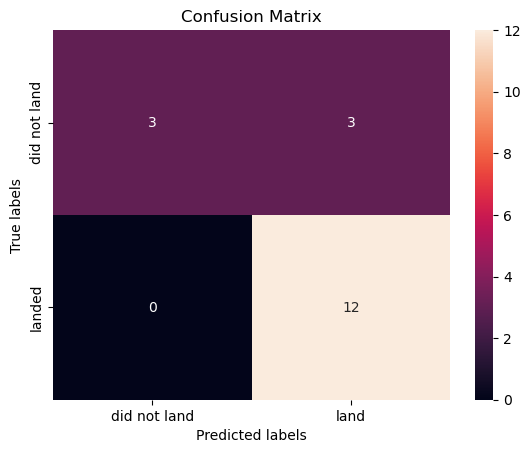

In [100]:
yhat=best_model.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, in our case we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.

*Results can vary due to stochastic nature of ML algorithms


### 6.5) SVM Model


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [101]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [102]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [103]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


Calculate the accuracy on the test data using the method <code>score</code>:


In [104]:
best_model = svm_cv.best_estimator_
# yhat = best_model.predict(X_test)
best_model.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


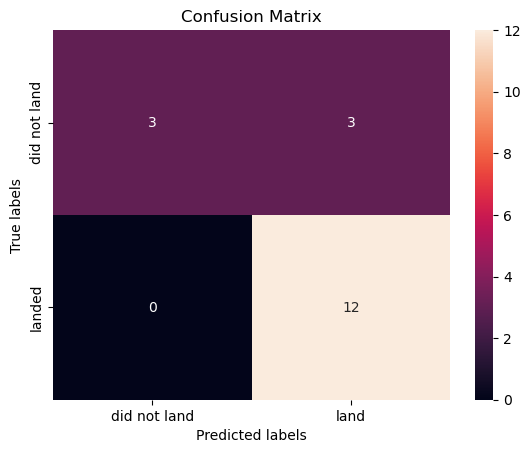

In [105]:
yhat=best_model.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### 6.6) Decision Tree Model

Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [106]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [107]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [108]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
accuracy : 0.8732142857142856


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [109]:
best_model = tree_cv.best_estimator_
# yhat = best_model.predict(X_test)
best_model.score(X_test, Y_test)

0.8888888888888888

We can plot the confusion matrix


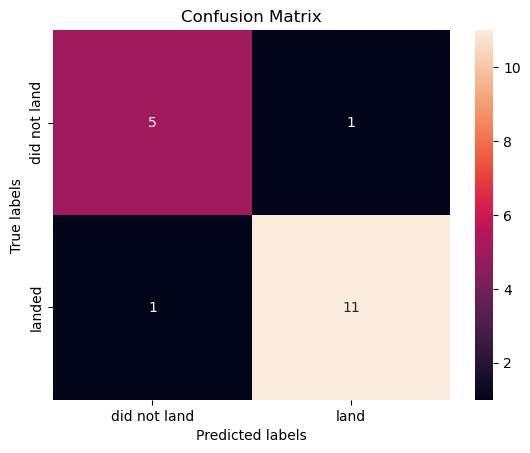

In [110]:
yhat = best_model.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### 6.7) KNN Model


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [111]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [112]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [113]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1}
accuracy : 0.8339285714285714


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [114]:
best_model = knn_cv.best_estimator_
# yhat = best_model.predict(X_test)
best_model.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


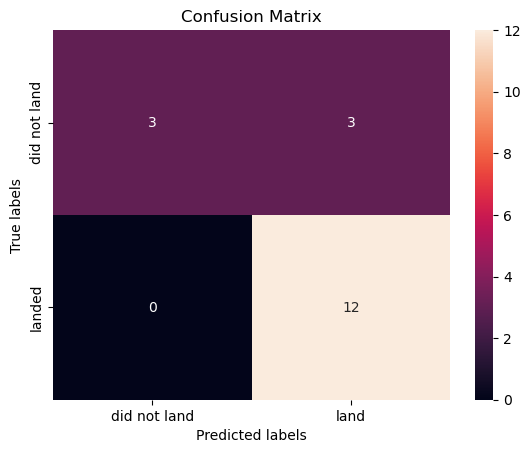

In [115]:
yhat = best_model.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### 6.8) Selecting the best model


Find the method performs best:


In [116]:
scores = [knn_cv.best_estimator_.score(X_test, Y_test), tree_cv.best_estimator_.score(X_test, Y_test), 
          svm_cv.best_estimator_.score(X_test, Y_test), logreg_cv.best_estimator_.score(X_test, Y_test)]

models = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']

results_df = pd.DataFrame({'Model': models, 'Accuracy': scores})

results_df = results_df.sort_values(by='Accuracy', ascending=False)

print(results_df)

                 Model  Accuracy
1        Decision Tree  0.888889
0                  KNN  0.833333
2                  SVM  0.833333
3  Logistic Regression  0.833333


It seems that (in our case) <code>Decision Tree</code> is the model with highest accuracy. Remember that this accuracies use the best hyperparameters for each model.